# Задача - найти кратчайший маршрут между несколькими городами Росии с помощью генетического алгоритма

## Визуализируем с помощью графа : Order – название города, откуда начинается путь, Destination – название города, до куда он продолжается, Distance – расстояние между городами, измеряемое в километрах.

          City 1             City 2  Distance
0    Blagodarnyy         Budonnovsk      70.0
1    Blagodarnyy         Svetlograd      68.0
2    Blagodarnyy        Zelenokumsk       NaN
3    Blagodarnyy         Neftekumsk       NaN
4    Blagodarnyy         Georgievsk       NaN
..           ...                ...       ...
301      Ipatovo       Nevinnomyssk       NaN
302      Ipatovo          Stavropol       NaN
303      Ipatovo  Novoaleksandrovsk       NaN
304      Ipatovo         Izobil'nyy     124.0
305      Ipatovo        Mikhaylovsk       NaN

[306 rows x 3 columns]


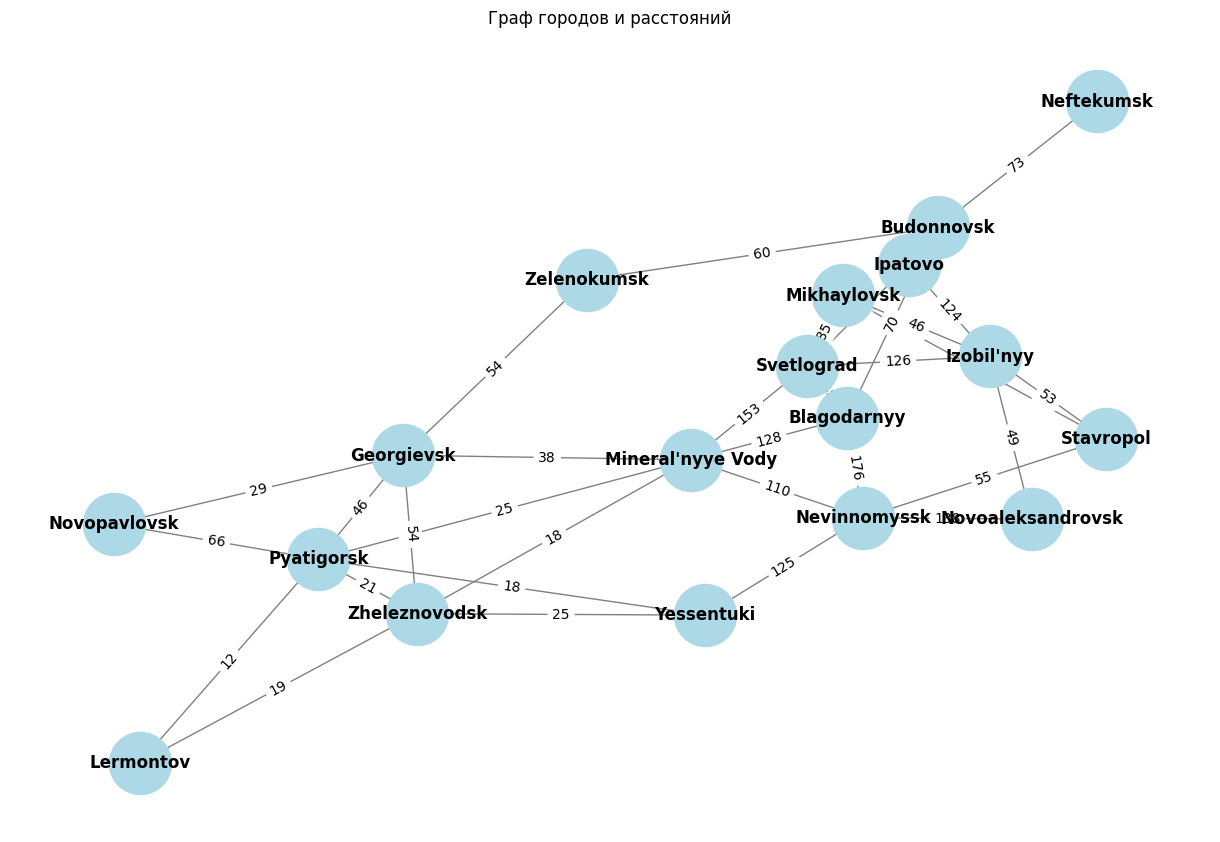

In [1]:
import pandas as pd
import networkx as nx
import random
import numpy
import numpy as np
import matplotlib.pyplot as plt

# Загружаем данные
data = pd.read_csv('C://AIM//static//csv//cities.csv')

# Создаем граф из данных
G = nx.Graph()
for _, row in data.iterrows():
    G.add_edge(row['Order'], row['Destination'], weight=row['Distance'])

# Проверяем связность графа
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

# Получаем список городов
cities_list = list(G.nodes())

# Создаем таблицу расстояний между городами
distance_data = []

for city1 in cities_list:
    for city2 in cities_list:
        if city1 != city2:
            distance = G[city1][city2]['weight'] if G.has_edge(city1, city2) else None
            distance_data.append({'City 1': city1, 'City 2': city2, 'Distance': distance})

# Создаем DataFrame
distance_df = pd.DataFrame(distance_data)

# Отображение таблицы
print(distance_df)

# Визуализация графа
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Расположение узлов
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')

# Отображение весов рёбер
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Граф городов и расстояний')
plt.axis('off')  # Скрыть оси
plt.show()

## Определим структуру хромосомы, реализуем фитнес-функцию и операторы мутаций

In [2]:
import numpy
class Chromosome:
    def __init__(self, cities):
        self.cities = cities.copy()
        self.distance = self.calculate_distance()
        
    def calculate_distance(self):
        """Вычисляет общее расстояние маршрута, учитывая возврат в начальный город."""
        total_distance = 0
        valid_edges = 0
        
        for i in range(len(self.cities)):
            city1 = self.cities[i]
            city2 = self.cities[(i + 1) % len(self.cities)]
            
            if G.has_edge(city1, city2):
                total_distance += G[city1][city2]['weight']
                valid_edges += 1
            else:
                avg_distance = np.mean([d['weight'] for u, v, d in G.edges(data=True)])
                total_distance += avg_distance * 2  # Штрафной коэффициент
                
        if valid_edges < len(self.cities):
            total_distance *= (1 + (len(self.cities) - valid_edges)/len(self.cities))
            
        return total_distance
    
    def fitness(self):
        """Фитнес-функция - обратная величина расстояния."""
        return 1 / (self.distance + 1e-6)  # Добавляем малое значение для избежания деления на 0
    
    def mutate(self, mutation_rate=0.1):
        """Мутация с разными операторами."""
        if random.random() < mutation_rate:
            mutation_type = random.choice(['swap', 'inversion', 'scramble'])
            
            if mutation_type == 'swap':
                idx1, idx2 = random.sample(range(len(self.cities)), 2)
                self.cities[idx1], self.cities[idx2] = self.cities[idx2], self.cities[idx1]
                
            elif mutation_type == 'inversion':
                start, end = sorted(random.sample(range(len(self.cities)), 2))
                self.cities[start:end] = self.cities[start:end][::-1]
                
            elif mutation_type == 'scramble':
                start, end = sorted(random.sample(range(len(self.cities)), 2))
                random.shuffle(self.cities[start:end])
            
            self.distance = self.calculate_distance()
    
    def __repr__(self):
        return f"Route: {self.cities}, Distance: {self.distance:.2f}"

## Сгенерируем начальную популяцию, оператор селекции и оператор кроссинговера

In [3]:
def generate_initial_population(pop_size, cities):
    """Генерирует начальную популяцию с проверкой валидности маршрутов."""
    population = []
    for _ in range(pop_size):
        chrom = Chromosome(random.sample(cities, len(cities)))
        population.append(chrom)
    return population

def tournament_selection(population, tournament_size=3):
    """Турнирный отбор."""
    participants = random.sample(population, tournament_size)
    return max(participants, key=lambda x: x.fitness())

def ordered_crossover(parent1, parent2):
    """Упорядоченный кроссовер (OX) для TSP."""
    size = len(parent1.cities)
    child_cities = [None] * size
    
    start, end = sorted(random.sample(range(size), 2))
    child_cities[start:end] = parent1.cities[start:end]
    
    remaining_cities = [city for city in parent2.cities if city not in child_cities[start:end]]
    
    ptr = 0
    for i in range(size):
        if child_cities[i] is None:
            child_cities[i] = remaining_cities[ptr]
            ptr += 1
    
    return Chromosome(child_cities)

## Определим основной генетический алгоритм

In [4]:
def genetic_algorithm(cities, pop_size=100, generations=500, mutation_rate=0.2, elitism=0.1):
    population = generate_initial_population(pop_size, cities)
    best_solution = min(population, key=lambda x: x.distance)
    history = [best_solution.distance]
    
    for generation in range(generations):
        population.sort(key=lambda x: x.distance)
        current_best = population[0]
        
        if current_best.distance < best_solution.distance:
            best_solution = current_best
        
        history.append(best_solution.distance)
        
        elites = population[:int(elitism * pop_size)]
        
        new_population = elites.copy()
        
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            child = ordered_crossover(parent1, parent2)
            child.mutate(mutation_rate)
            new_population.append(child)
        
        population = new_population
        
        if generation % 10 == 0:
            avg_dist = np.mean([chrom.distance for chrom in population])
            print(f"Generation {generation}: Best = {best_solution.distance:.2f}, Avg = {avg_dist:.2f}")

    return best_solution

## Напишем функцию experinment, она нужна для исследования, как изменение размера популяции и вероятности мутации влияют на эффективность генетического алгоритма

In [5]:
test_cities = cities_list[:20]
def experiment(pop_sizes, mutation_rates, generations=200):
    for pop_size in pop_sizes:
        for mutation_rate in mutation_rates:
            best_route = genetic_algorithm(
                cities=test_cities,
                pop_size=pop_size,
                generations=generations,
                mutation_rate=mutation_rate,
                elitism=0.1
            )
            print(f"Population Size: {pop_size}, Mutation Rate: {mutation_rate} -> Best Distance: {best_route.distance:.2f}")

## Попробуем в действии

In [6]:
# Вызов функции для экспериментов
pop_sizes = [50, 100, 200]  # Разные размеры популяции
mutation_rates = [0.05, 0.1, 0.15]  # Разные вероятности мутации
experiment(pop_sizes, mutation_rates)

Generation 0: Best = 3047.82, Avg = 3508.01
Generation 10: Best = 1981.60, Avg = 2153.80
Generation 20: Best = 1907.33, Avg = 1909.47
Generation 30: Best = 1798.15, Avg = 1849.95
Generation 40: Best = 1798.15, Avg = 1812.55
Generation 50: Best = 1749.60, Avg = 1794.85
Generation 60: Best = 1749.60, Avg = 1753.47
Generation 70: Best = 1732.99, Avg = 1782.18
Generation 80: Best = 1715.10, Avg = 1715.10
Generation 90: Best = 1715.10, Avg = 1715.10
Generation 100: Best = 1715.10, Avg = 1739.90
Generation 110: Best = 1715.10, Avg = 1736.12
Generation 120: Best = 1625.65, Avg = 1739.88
Generation 130: Best = 1616.71, Avg = 1634.26
Generation 140: Best = 1616.71, Avg = 1624.55
Generation 150: Best = 1423.89, Avg = 1564.71
Generation 160: Best = 1421.44, Avg = 1511.65
Generation 170: Best = 1362.38, Avg = 1463.22
Generation 180: Best = 1354.21, Avg = 1366.55
Generation 190: Best = 1257.38, Avg = 1282.88
Population Size: 50, Mutation Rate: 0.05 -> Best Distance: 1257.38
Generation 0: Best = 300

## Запустим процесс выполнения основного генетического алгоритма

Running GA for 18 cities: ['Blagodarnyy', 'Budonnovsk', 'Svetlograd', 'Zelenokumsk', 'Neftekumsk', 'Georgievsk', 'Novopavlovsk', 'Pyatigorsk', "Mineral'nyye Vody", 'Zheleznovodsk', 'Lermontov', 'Yessentuki', 'Nevinnomyssk', 'Stavropol', 'Novoaleksandrovsk', "Izobil'nyy", 'Mikhaylovsk', 'Ipatovo']
Generation 0: Best = 3094.54, Avg = 3595.11
Generation 10: Best = 1874.00, Avg = 2382.15
Generation 20: Best = 1332.04, Avg = 1483.60
Generation 30: Best = 1252.78, Avg = 1366.30
Generation 40: Best = 1252.78, Avg = 1279.34
Generation 50: Best = 1252.78, Avg = 1277.41
Generation 60: Best = 1252.78, Avg = 1284.11
Generation 70: Best = 1252.78, Avg = 1277.57
Generation 80: Best = 1252.78, Avg = 1290.92
Generation 90: Best = 1252.78, Avg = 1277.69
Generation 100: Best = 1252.78, Avg = 1273.81
Generation 110: Best = 1252.78, Avg = 1276.56
Generation 120: Best = 1252.78, Avg = 1307.13
Generation 130: Best = 1252.78, Avg = 1276.88
Generation 140: Best = 1252.78, Avg = 1290.22
Generation 150: Best = 

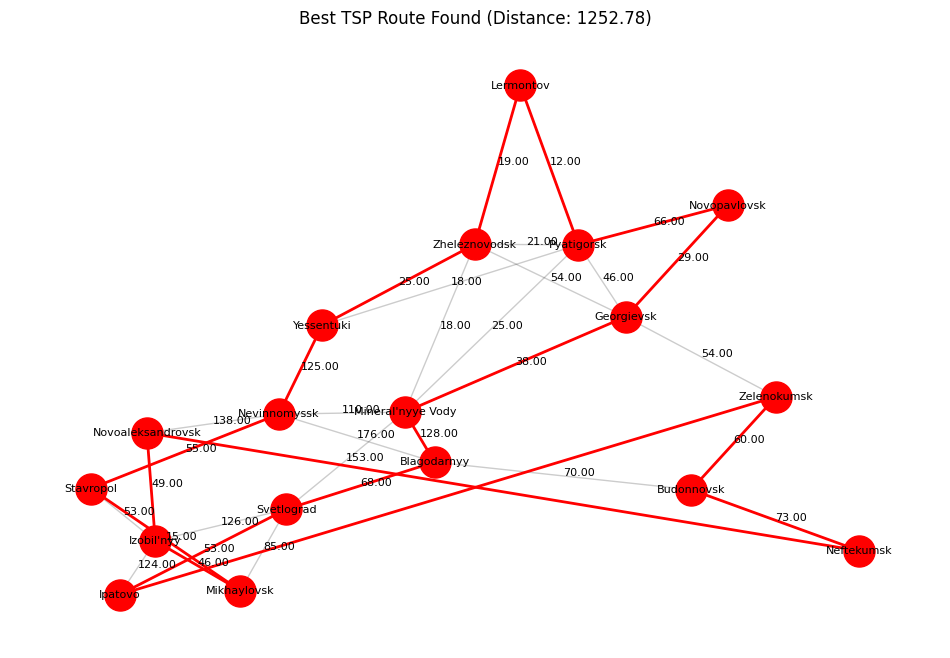

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

if __name__ == "__main__":
    test_cities = cities_list[:20]
    print(f"Running GA for {len(test_cities)} cities: {test_cities}")

    best_route = genetic_algorithm(
        cities=test_cities,
        pop_size=100,
        generations=200,
        mutation_rate=0.15,
        elitism=0.1
    )

    print("\nBest solution found:")
    print(best_route)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    route_edges = [(best_route.cities[i], best_route.cities[(i + 1) % len(best_route.cities)])
                   for i in range(len(best_route.cities))]

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='r', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=best_route.cities, node_size=500, node_color='r')

    # Подпись расстояний на графике для всех ребер
    for city1, city2 in G.edges():
        distance = G[city1][city2]['weight']  # Получение веса (расстояния)
        if distance is not None:  # Проверка, что расстояние определено
            x1, y1 = pos[city1]  # Координаты первого города
            x2, y2 = pos[city2]  # Координаты второго города
            # Позиция для подписи (середина ребра)
            plt.text((x1 + x2) / 2, (y1 + y2) / 2, f'{distance:.2f}', fontsize=8, color='black')

    plt.title(f"Best TSP Route Found (Distance: {best_route.distance:.2f})")
    plt.axis('off')
    plt.show()